Notebook Logistic Regression Case
Oefening Data Scientist 
Geert Vandezande

Doel:
- Supervised Learning toepassen
- EDA uitvoeren op een dataset
- Lineair Regression toepassen op de data

Dataset: 
- More info: see kaggle https://www.kaggle.com/datasets/arifmia/heart-attack-risk-dataset


Volgorde van activiteiten in deze notebook: (cfr Datacamp "preparing data for modelling)
- data inlezen
- data bekijken, visueel en numerisch
- missing data oplossen 
- incorrect types controleren
- Numerische waarde standardizeren
- Categorische varaiabelen processen
- Feature engineering
- select features for modelling

In [10]:
# import van de diverse modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import plot_importance

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

In [11]:
# extra code overal gebruikt

# extra code – code to save the figures as high-res PNGs for the book
from pathlib import Path
import matplotlib.pyplot as plt

IMAGES_PATH = Path() / "images" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)



def plot_overzicht_kolommen(df_plot, num_columns = 3, figuur_naam = 'Overzicht kolommen', bins = 50):    
    num_plots = len(df_plot.columns)
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))
    axes = axes.flatten()
    for i, column in enumerate(df_plot.columns):
        df_plot[column].hist(bins, ax=axes[i])
        axes[i].set_title(column)
    # Hide any unused subplots
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    save_fig(figuur_naam)
    plt.show()


def plot_histogram(df_hist, column, bins = 50, figuur_naam = 'Overzicht kolommen'):
    plt.rc('font', size=14)
    plt.rc('axes', labelsize=14, titlesize=14)
    plt.rc('legend', fontsize=14)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    # plt.hist(df_hist[column], color='blue', alpha=0.7)
    plt.title('Histogram van Heart Rate')
    plt.xlabel('Heart Rate')
    plt.ylabel('Frequentie')
    df_hist[column].hist(bins, figsize=(12, 8))
    save_fig(figuur_naam)  # extra code
    plt.show()

In [ ]:
# data inlezen van de file

df = pd.read_csv('data/heart_attack_risk_dataset.csv')

# lijst met features opgedeeld in numerisch en categorisch
df_col = ['Age', 'Gender', 'Smoking', 'Alcohol_Consumption',
       'Physical_Activity_Level', 'BMI', 'Diabetes', 'Hypertension',
       'Cholesterol_Level', 'Resting_BP', 'Heart_Rate', 'Family_History',
       'Stress_Level', 'Chest_Pain_Type', 'Thalassemia', 'Fasting_Blood_Sugar',
       'ECG_Results', 'Exercise_Induced_Angina', 'Max_Heart_Rate_Achieved',
       'Heart_Attack_Risk']

# bepaal eerst de opdeling van numerische en categorische waarden op basis van de kolommen
# 3 opties

# optie 1: op basis van het datatype in de kolome
# df_num_col = df.select_dtypes(include='number').columns
# df_cat_col = df.select_dtypes(include='object').columns


# optie 2: op basis van de voorkomens van de waarden, indien <=4 is het een categorische 
# minder goed
df_cat_col = [i for i in df.columns if df[i].nunique() <= 4]
df_num_col= [i for i in df.columns if i not in df_cat_col]

# optie 3: en dit is de manuele manier om de lijst van kolommen voor numerische en categorische waarden samen te stellen
# check in via info() en describe() 
# we gaan dit verder gebruiken
df_num_col = ['Age', 'BMI', 'Cholesterol_Level', 'Resting_BP', 'Heart_Rate', 'Max_Heart_Rate_Achieved']
df_cat_col = ['Gender', 'Smoking', 'Alcohol_Consumption', 'Physical_Activity_Level', 'Diabetes', 'Hypertension', 'Family_History', 'Stress_Level',
              'Chest_Pain_Type', 'Thalassemia', 'Fasting_Blood_Sugar','ECG_Results', 'Exercise_Induced_Angina', 'Heart_Attack_Risk']

df_num = df[df_num_col]
df_cat = df[df_cat_col]
print(df_num.head())
print(df_cat.head())



   Age    BMI  Cholesterol_Level  Resting_BP  Heart_Rate  \
0   69  34.61              152.1         171          85   
1   32  22.75              166.8         126         103   
2   89  35.32              272.3         123         127   
3   78  18.23              237.7         144         125   
4   38  19.82              207.7         123         107   

   Max_Heart_Rate_Achieved  
0                      114  
1                      173  
2                      109  
3                      129  
4                      124  
   Gender  Smoking  Alcohol_Consumption Physical_Activity_Level  Diabetes  \
0  Female        1                    0                Moderate         1   
1    Male        0                    0                Moderate         0   
2    Male        0                    1                Moderate         0   
3    Male        0                    1                Moderate         1   
4  Female        1                    0                Moderate         0   

  

In [13]:
# eerste controles

df.head()
df.describe()
df.info()

print(df.columns)

# check op nulwaarden:
df.isnull().sum()
# ok, geen nulwaarden

df.duplicated().sum()
# ok, geen duplicates

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      50000 non-null  int64  
 1   Gender                   50000 non-null  object 
 2   Smoking                  50000 non-null  int64  
 3   Alcohol_Consumption      50000 non-null  int64  
 4   Physical_Activity_Level  50000 non-null  object 
 5   BMI                      50000 non-null  float64
 6   Diabetes                 50000 non-null  int64  
 7   Hypertension             50000 non-null  int64  
 8   Cholesterol_Level        50000 non-null  float64
 9   Resting_BP               50000 non-null  int64  
 10  Heart_Rate               50000 non-null  int64  
 11  Family_History           50000 non-null  int64  
 12  Stress_Level             50000 non-null  object 
 13  Chest_Pain_Type          50000 non-null  object 
 14  Thalassemia           

np.int64(0)

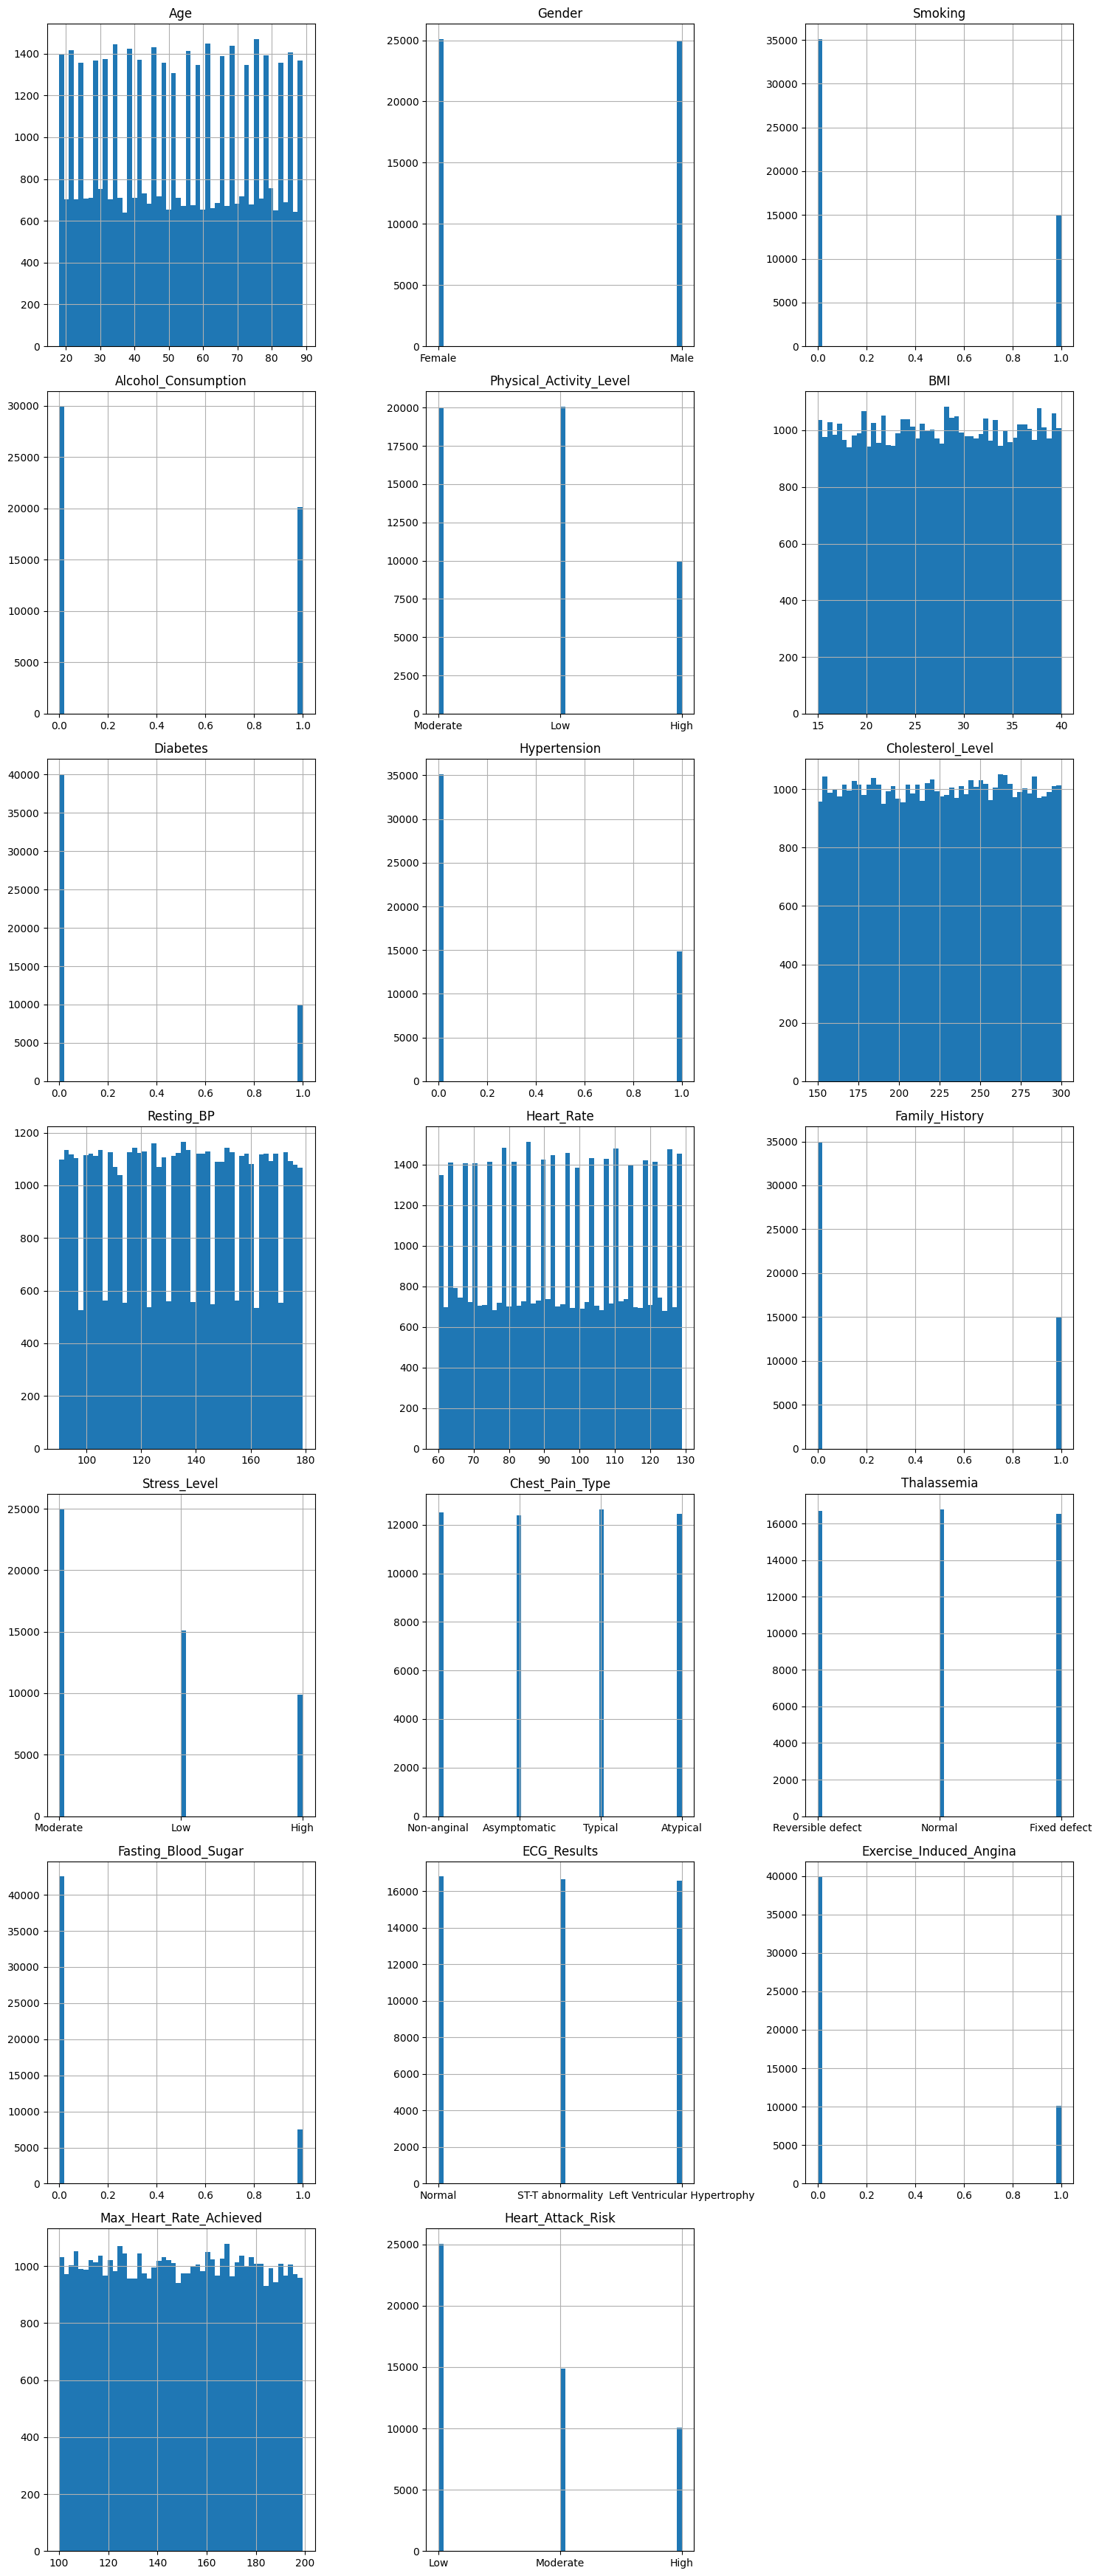

In [14]:
# snelle blik op de variabelen
# algemene plot van de variabelen

num_columns = 3
num_plots = len(df.columns)
num_rows = (num_plots + num_columns - 1) // num_columns
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))
axes = axes.flatten()
for i, column in enumerate(df.columns):
    df[column].hist(bins=50, ax=axes[i])
    axes[i].set_title(column)
# Hide any unused subplots
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
save_fig("algemeen_overzicht_features")
plt.show()

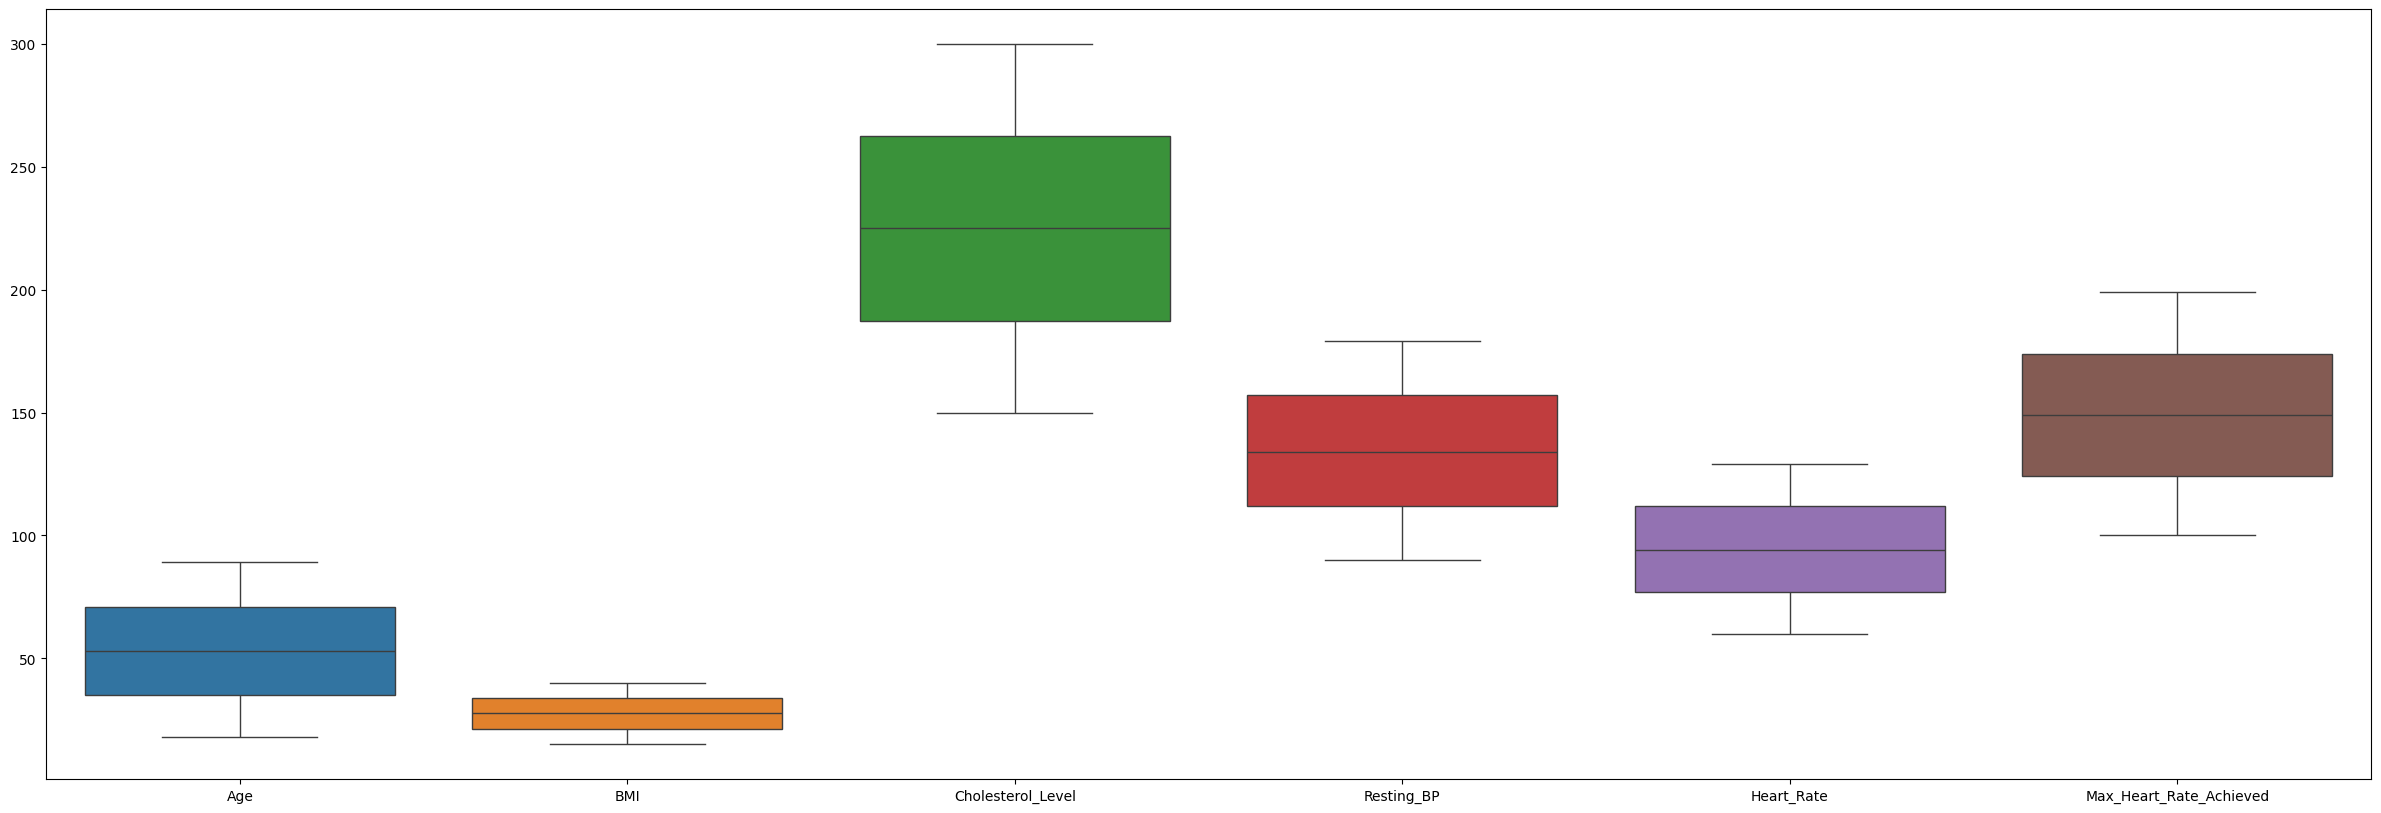

C:\Users\geert\AppData\Local\Temp\ipykernel_38700\68602168.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppData\Local\Temp\ipykernel_38700\68602168.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppData\Local\Temp\ipykernel_38700\68602168.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppData\Local\Temp\ipykernel_38700\68602168.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppData\Local\Temp\ipykernel_38700\68602168.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppDa

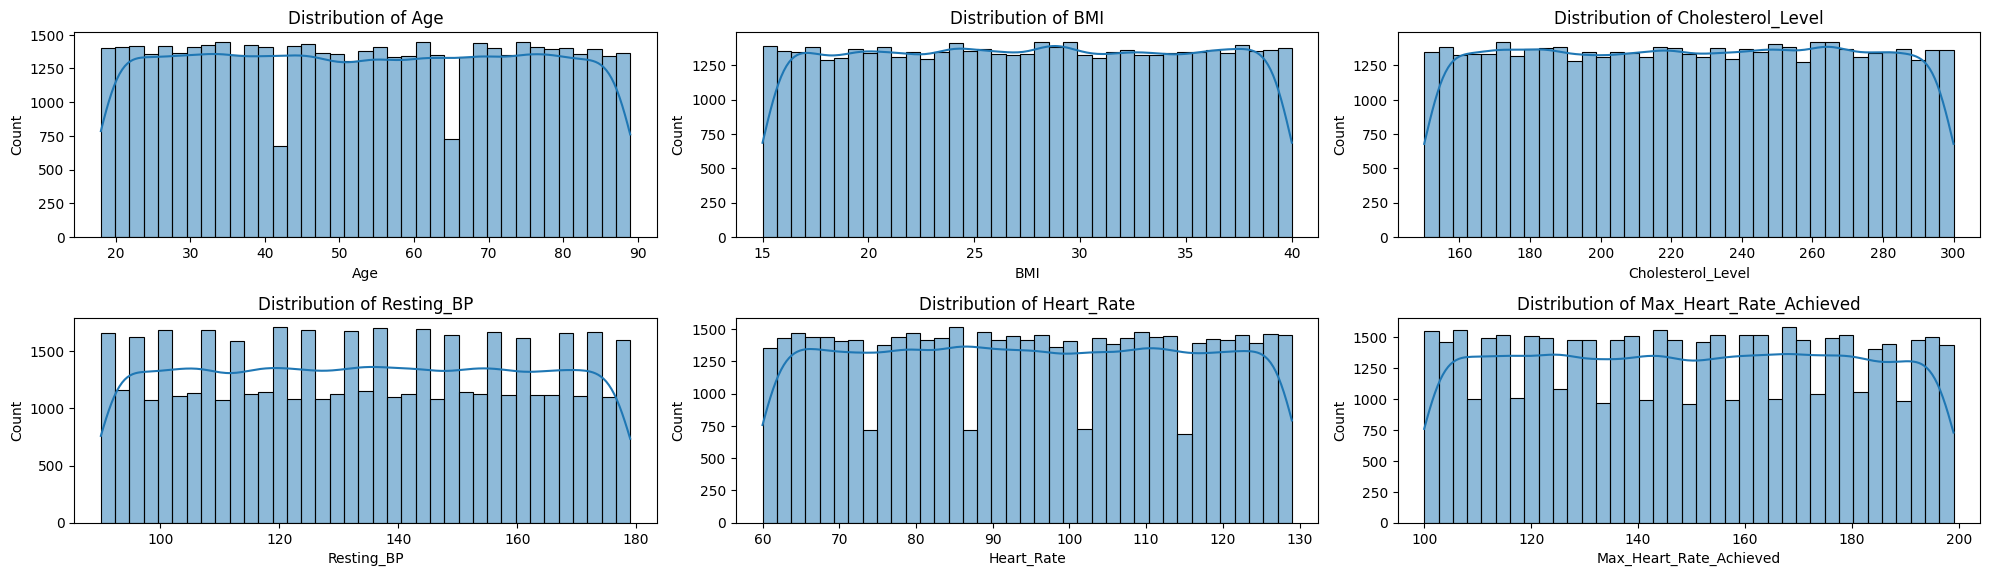

In [15]:
# analyze van de features, eerst de numerische features
# eerst een boxplot, voor de numerische waarde

fig = plt.figure(figsize=(30,10))
sns.boxplot(df_num)
plt.show()

# dan de variantie
df_num.describe()


plt.figure(figsize=(20,14))

for i, col in enumerate(df_num_col,1):
    plt.subplot(5,3,i)
    sns.histplot(df[col], kde=True, palette='skyblue')
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()






   Gender  Smoking  Alcohol_Consumption Physical_Activity_Level  Diabetes  \
0  Female        1                    0                Moderate         1   
1    Male        0                    0                Moderate         0   
2    Male        0                    1                Moderate         0   
3    Male        0                    1                Moderate         1   
4  Female        1                    0                Moderate         0   

   Hypertension  Family_History Stress_Level Chest_Pain_Type  \
0             0               0     Moderate     Non-anginal   
1             0               0          Low    Asymptomatic   
2             0               0          Low         Typical   
3             0               0          Low         Typical   
4             0               0         High    Asymptomatic   

         Thalassemia  Fasting_Blood_Sugar                   ECG_Results  \
0  Reversible defect                    0                        Normal   
1 

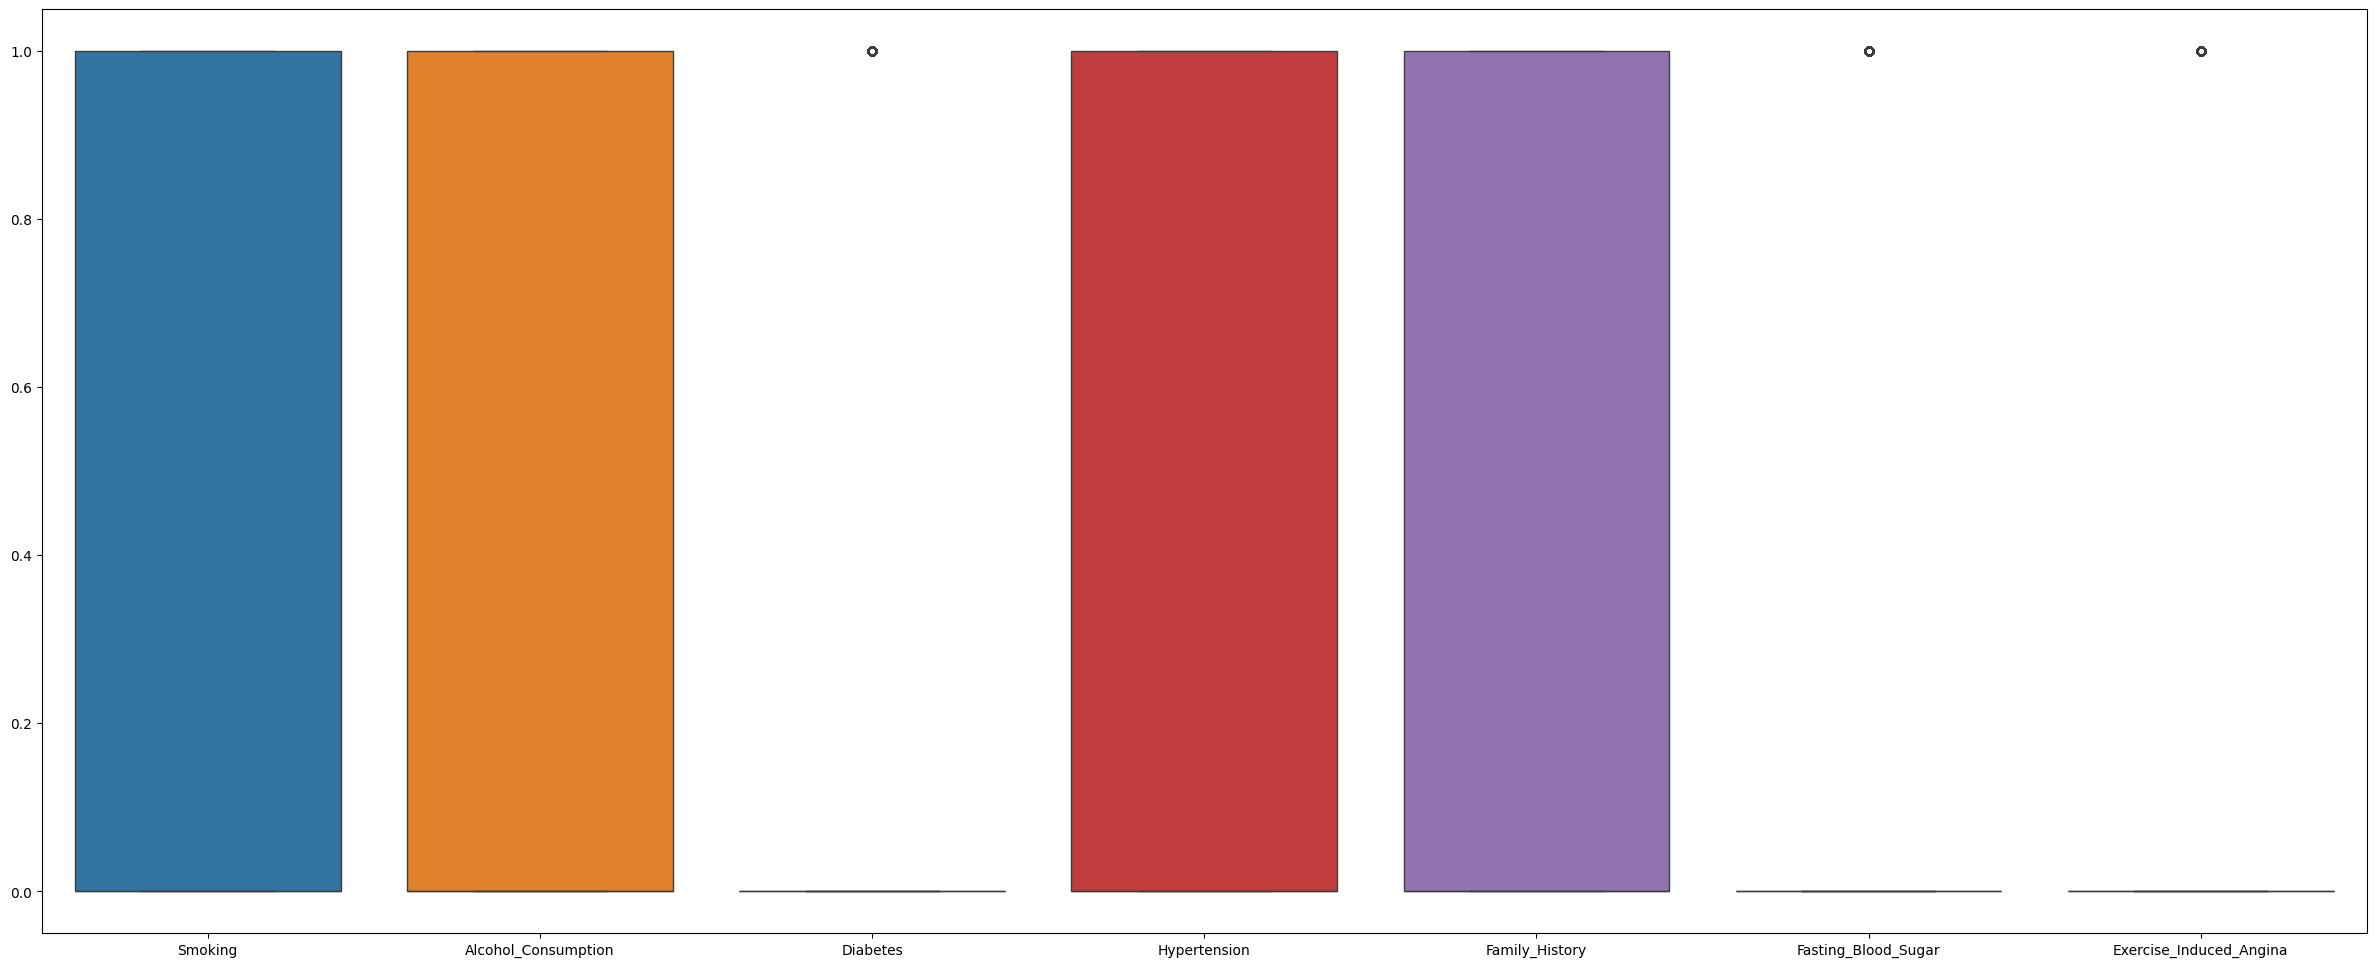

,Smoking,Alcohol_Consumption,Diabetes,Hypertension,Family_History,Fasting_Blood_Sugar,Exercise_Induced_Angina
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000
mean,0.298420,0.401980,0.198840,0.29738,0.30034,0.149360,0.201640
std,0.457569,0.490303,0.399131,0.45711,0.45841,0.356447,0.401229
min,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.00000,1.00000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000


In [16]:
# analyze van de features, eerst de categorische features
# eerst een boxplot


print(df_cat.head())

fig = plt.figure(figsize=(30,12))
sns.boxplot(df_cat)
plt.show()

# dan de variantie
df_cat.describe()

['Gender', 'Smoking', 'Alcohol_Consumption', 'Physical_Activity_Level', 'Diabetes', 'Hypertension', 'Family_History', 'Stress_Level', 'Chest_Pain_Type', 'Thalassemia', 'Fasting_Blood_Sugar', 'ECG_Results', 'Exercise_Induced_Angina', 'Heart_Attack_Risk']
['Age', 'BMI', 'Cholesterol_Level', 'Resting_BP', 'Heart_Rate', 'Max_Heart_Rate_Achieved']


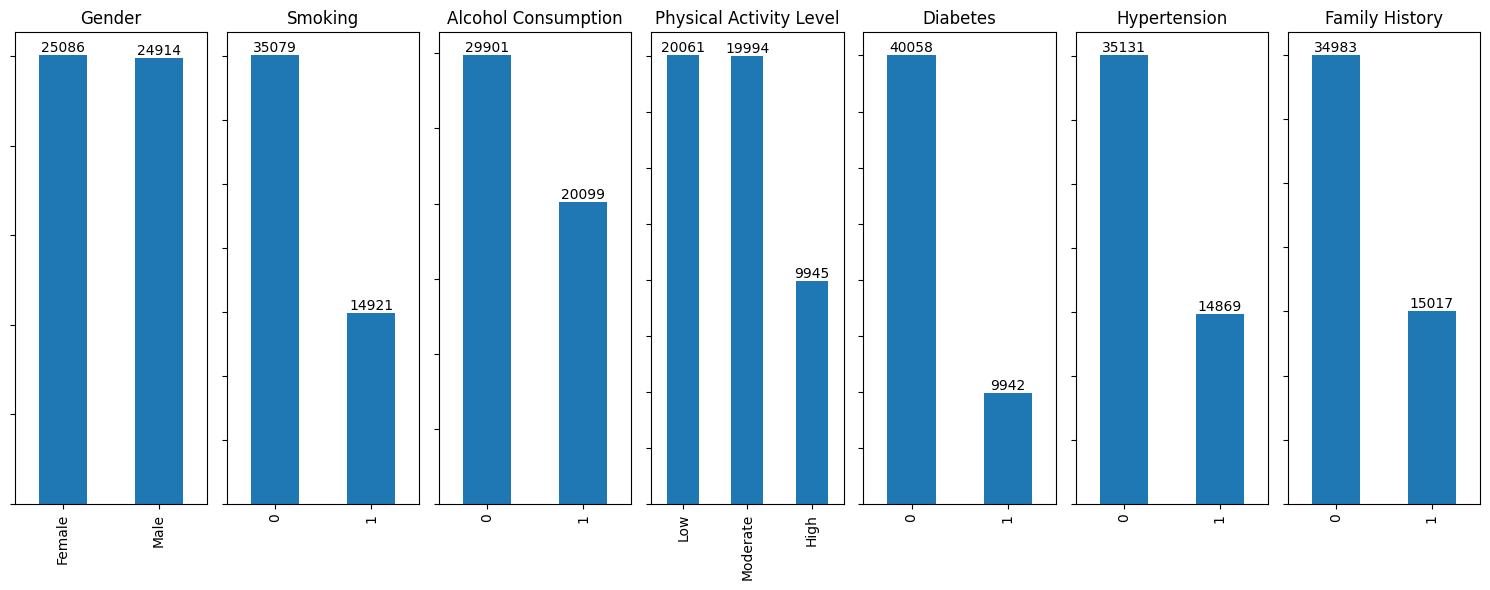

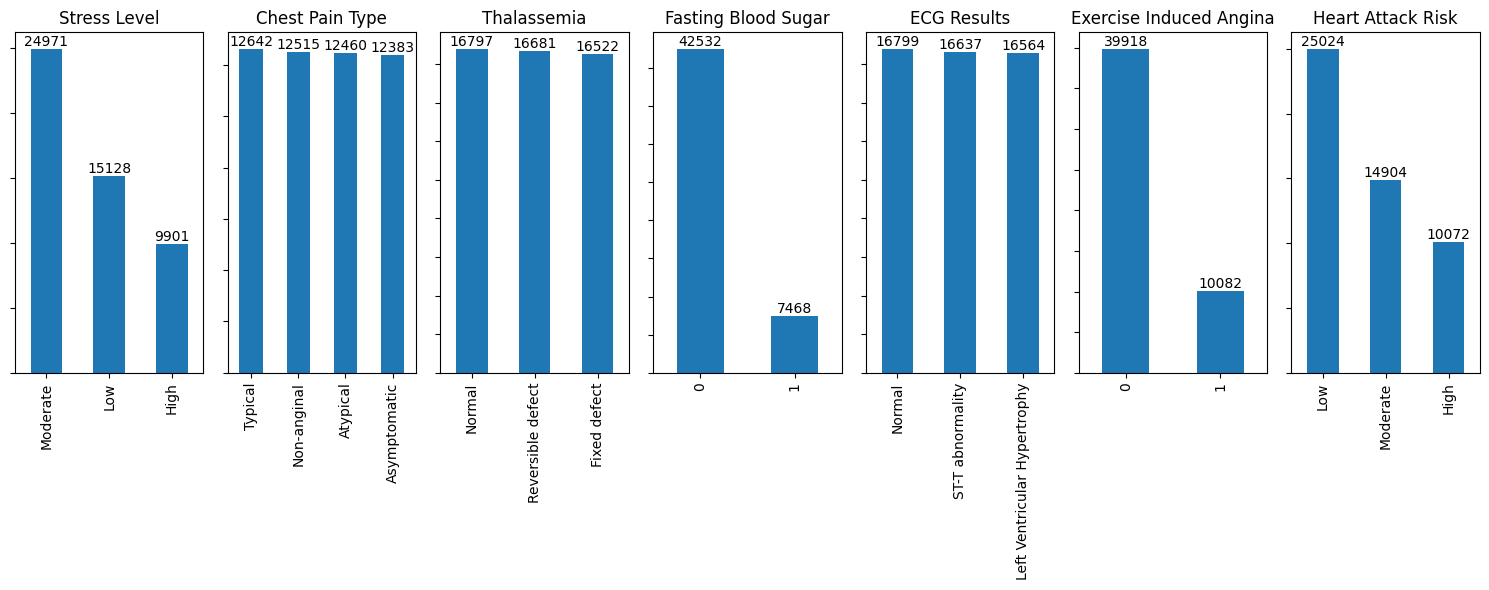

In [ ]:


print(cats)
print(nums)

index = 0

def bar_labels(axes, rotation=0, location="edge"):
    for container in axes.containers:
        axes.bar_label(container, rotation=rotation, label_type=location)
    axes.set_ylabel("")
    axes.set_xlabel("")
    axes.set_yticklabels(())

for _ in range(2):
    fig, axes = plt.subplots(ncols=7, figsize=(15, 6))
    for i in range(7):
        df[cats[index]].value_counts().plot(kind="bar", ax=axes[i])
        bar_labels(axes[i])
        axes[i].set_title(cats[index].replace('_', ' '))
        index+=1
    plt.tight_layout()
    plt.show()

In [ ]:
# Create correaltion heatmap
fig = plt.figure(figsize=(30,30))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.show()